In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_excel('calcific_tendinopathy_ddbb.xlsx')

In [3]:
data.head(30)

,image,calcium,pat_id,type,localization
0,0072879_001.png,1,72879,2,supraespinoso
1,0072879_002.png,1,72879,2,supraespinoso
2,00326955M_001.png,1,326955M,3,supraespinoso
3,00326955M_002.png,1,326955M,3,supraespinoso
4,0094847_001.png,0,94847,-1,NaN
5,00486523M_001.png,1,486523M,2,infraespinoso
6,00486523M_002.png,1,486523M,2,infraespinoso
7,00564810_001.png,1,564810,1,supraespinoso
8,00564810_002.png,1,564810,1,supraespinoso
9,00782404_001.png,1,782404,1,supraespinoso


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        rotation_range = 15,
        zoom_range=0.2,
        horizontal_flip=True)

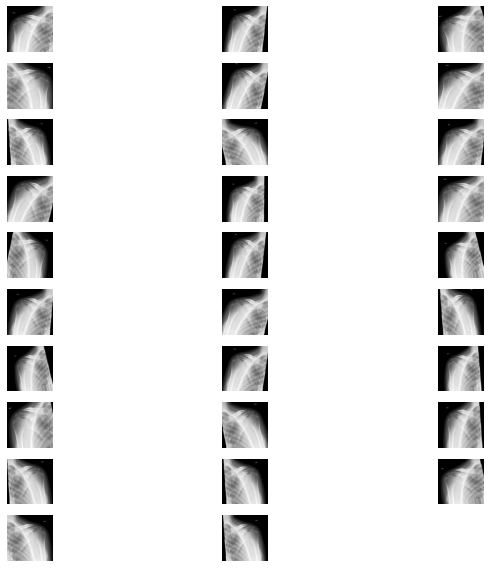

In [5]:
# let's plot some of the figures

from tensorflow.keras.preprocessing import image

fnames = [os.path.join('train/class_1',fname) for fname in os.listdir('train/class_1')]


img_path = fnames[1]

#reads image

img = image.load_img(img_path,target_size = (150,150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 1

plt.figure(figsize = (10,8))

for batch in train_datagen.flow(x,batch_size = 10):
    plt.subplot(10,3,i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 30 == 0:
        break
    
plt.tight_layout()

In [6]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [7]:
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
        'valid',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        'valid',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 24 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [22]:
#load ChestXnet model
from tensorflow.keras.applications import DenseNet121
    
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(224,224,3), pooling="avg")

predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(base_model.output)
base_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights("CheXNet_Keras_0.3.0_weights.h5")
base_model.layers.pop()

In [14]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [37]:
# remove last layer to create our top layers
from tensorflow.keras import Model
new_model = Model(base_model.inputs, base_model.layers[-2].output)
#freezing the weights
new_model.trainable = False

new_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [50]:
#add two dense layers on top of the conv_base

#x = layers.Dense(64, activation='relu',name = 'dense_layer')(new_model.output)
output = layers.Dense(1,activation = "sigmoid",name = 'output_layer')(new_model.output)

model = Model(new_model.inputs,output)


model.summary()


Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [51]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [52]:
batch_size = 100
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(
    train_generator,
    epochs=30,
    validation_data = validation_generator,
)

Epoch 1/30
1/1 [==============================] - 11s 11s/step - loss: 0.8047 - binary_accuracy: 0.2917 - val_loss: 0.7331 - val_binary_accuracy: 0.3750
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 0.7664 - binary_accuracy: 0.2917 - val_loss: 0.7094 - val_binary_accuracy: 0.3750
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 0.7280 - binary_accuracy: 0.3333 - val_loss: 0.6900 - val_binary_accuracy: 0.6250
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 0.6932 - binary_accuracy: 0.4583 - val_loss: 0.6751 - val_binary_accuracy: 0.6250
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 0.6716 - binary_accuracy: 0.5833 - val_loss: 0.6643 - val_binary_accuracy: 0.6250
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 0.6506 - binary_accuracy: 0.7083 - val_loss: 0.6577 - val_binary_accuracy: 0.6250
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 0.6281 - binary_accurac

In [53]:
test_lost, test_acc = model.evaluate_generator(validation_generator)
print(test_acc)

/home/obarquero/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.625


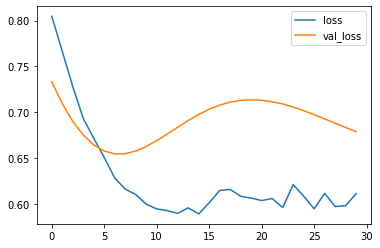

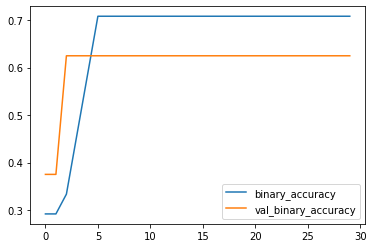

In [54]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();